# **DRILL: fixing assumptions**

In [139]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

## **Assumption one: linear relationship**

In [140]:
# Acquire, load, and preview the data.
data = pd.read_csv('https://tf-curricula-prod.s3.amazonaws.com/data-science/Advertising.csv')
display(data.head())

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = data['Sales'].values.reshape(-1, 1)
X1 = data[['TV','Radio','Newspaper']]

# Create new squared features
data['TV^2'] = data['TV']**2
data['Radio^2'] = data['Radio']**2
data['Newspaper^2'] = data['Newspaper']**2
data['Sales^2'] = data['Sales']**2

X2 = data[['TV^2', 'Radio^2', 'Newspaper^2']]

regr.fit(X2, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X2, Y))

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.100,37.800,69.200,22.100
1,2,44.500,39.300,45.100,10.400
2,3,17.200,45.900,69.300,9.300
3,4,151.500,41.300,58.500,18.500
4,5,180.800,10.800,58.400,12.900



Coefficients: 
 [[  1.42707531e-04   3.68654872e-03  -8.28260101e-05]]

Intercept: 
 [ 7.2029644]

R-squared:
0.799973684425


## **Assumption two: multivariate normality**

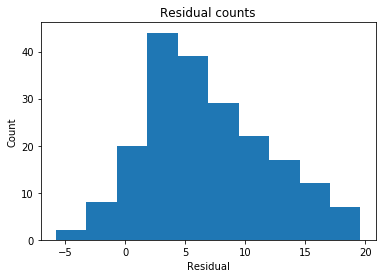

In [141]:
Y = data['Sales'].values.reshape(-1, 1)
X = data[['TV', 'Radio', 'Newspaper']]

# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['Sales']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

## **Assumption three: homoscedasticity**

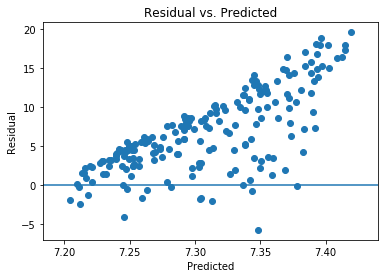

In [142]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

Based on the scatter plot, it appears as though squaring the features improved the homoscedasticity.

## **Assumption four: low multicollinearity**

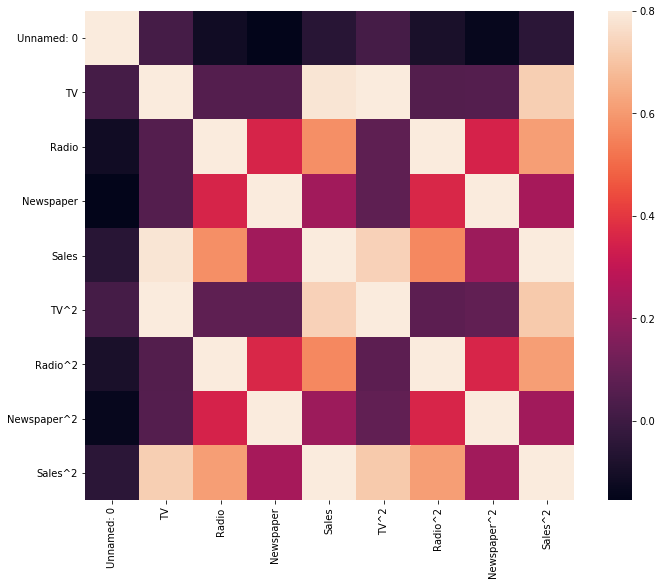

,Unnamed: 0,TV,Radio,Newspaper,Sales,TV^2,Radio^2,Newspaper^2,Sales^2
Unnamed: 0,1.000,0.018,-0.111,-0.155,-0.052,0.018,-0.091,-0.137,-0.043
TV,0.018,1.000,0.055,0.057,0.782,0.968,0.051,0.056,0.729
Radio,-0.111,0.055,1.000,0.354,0.576,0.079,0.967,0.352,0.610
Newspaper,-0.155,0.057,0.354,1.000,0.228,0.076,0.361,0.940,0.238
Sales,-0.052,0.782,0.576,0.228,1.000,0.736,0.562,0.216,0.980
TV^2,0.018,0.968,0.079,0.076,0.736,1.000,0.075,0.085,0.715
Radio^2,-0.091,0.051,0.967,0.361,0.562,0.075,1.000,0.357,0.611
Newspaper^2,-0.137,0.056,0.352,0.940,0.216,0.085,0.357,1.000,0.228
Sales^2,-0.043,0.729,0.610,0.238,0.980,0.715,0.611,0.228,1.000


In [143]:
corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()
display(data.corr())

It appears that some of our features are highly correlated, particularly Radio/Sales and Newspaper/Sales.

In [144]:
correlation_matrix = data.corr()
display(correlation_matrix)

,Unnamed: 0,TV,Radio,Newspaper,Sales,TV^2,Radio^2,Newspaper^2,Sales^2
Unnamed: 0,1.000,0.018,-0.111,-0.155,-0.052,0.018,-0.091,-0.137,-0.043
TV,0.018,1.000,0.055,0.057,0.782,0.968,0.051,0.056,0.729
Radio,-0.111,0.055,1.000,0.354,0.576,0.079,0.967,0.352,0.610
Newspaper,-0.155,0.057,0.354,1.000,0.228,0.076,0.361,0.940,0.238
Sales,-0.052,0.782,0.576,0.228,1.000,0.736,0.562,0.216,0.980
TV^2,0.018,0.968,0.079,0.076,0.736,1.000,0.075,0.085,0.715
Radio^2,-0.091,0.051,0.967,0.361,0.562,0.075,1.000,0.357,0.611
Newspaper^2,-0.137,0.056,0.352,0.940,0.216,0.085,0.357,1.000,0.228
Sales^2,-0.043,0.729,0.610,0.238,0.980,0.715,0.611,0.228,1.000


In [145]:
features = ['TV', 'Radio', 'Newspaper', 'TV^2', 'Radio^2', 'Newspaper^2', 'Sales^2']

df_pca = data.loc[:, features].values
y = data.loc[:, ['Sales']].values

X = StandardScaler().fit_transform(df_pca)

Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

Covariance Matrix:
 [[ 1.00502513  0.05508408  0.05693254  0.97252509  0.05109954  0.05590531
   0.73256521]
 [ 0.05508408  1.00502513  0.35588317  0.07903933  0.97160989  0.3541069
   0.6134916 ]
 [ 0.05693254  0.35588317  1.00502513  0.07682624  0.36322152  0.94439868
   0.23939276]
 [ 0.97252509  0.07903933  0.07682624  1.00502513  0.07509284  0.08590238
   0.7185557 ]
 [ 0.05109954  0.97160989  0.36322152  0.07509284  1.00502513  0.3583038
   0.61367703]
 [ 0.05590531  0.3541069   0.94439868  0.08590238  0.3583038   1.00502513
   0.22896125]
 [ 0.73256521  0.6134916   0.23939276  0.7185557   0.61367703  0.22896125
   1.00502513]]


In [146]:
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].reshape(1, 7).T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[[-0.32192638]
 [-0.41441704]
 [-0.32480276]
 [-0.33074094]
 [-0.41479104]
 [-0.32324108]
 [-0.48290695]]
Eigenvalue 1: 3.3533907440501256
----------------------------------------
Eigenvector 2: 
[[-0.53183042]
 [ 0.26803955]
 [ 0.35554971]
 [-0.51574108]
 [ 0.27193793]
 [ 0.35385085]
 [-0.23183203]]
Eigenvalue 2: 2.138315141603013
----------------------------------------
Eigenvector 3: 
[[ 0.16157412]
 [-0.4372079 ]
 [ 0.51608197]
 [ 0.16734606]
 [-0.43358999]
 [ 0.52089634]
 [-0.17048307]]
Eigenvalue 3: 1.3152329266320908
----------------------------------------
Eigenvector 4: 
[[ 0.13700407]
 [ 0.2664073 ]
 [-0.13288173]
 [ 0.44772813]
 [ 0.22523894]
 [ 0.09618972]
 [-0.7950811 ]]
Eigenvalue 4: 0.10705708130779526
----------------------------------------
Eigenvector 5: 
[[ 0.10729353]
 [ 0.01308928]
 [ 0.69087275]
 [ 0.00494538]
 [ 0.07675588]
 [-0.69424467]
 [-0.15205271]]
Eigenvalue 5: 0.05981778381043827
----------------------------------------
Eigenvector 6: 
[[-

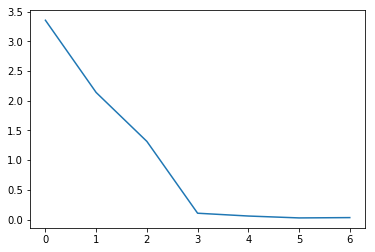

In [147]:
plt.plot(eig_val_cov)
plt.show()

It turns out that doing PCA indicates that we should get rid of the extra squared features. Only the first three features (TV, Radio, Newspaper) have eigenvalues greater than 1. Approximately 96% of the variance is captured in these three features.